In [1]:
import os
import datetime
import importlib 
import torchkeras

In [2]:
# 打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s" % nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

## 一、准备数据

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
f_path = './data/COVID-19/covid-19.csv'
df = pd.read_csv(f_path, sep='\t')
df.head(10)

,date,confirmed_num,cured_num,dead_num
0,2020-01-24,830.0,34.0,25.0
1,2020-01-25,1287.0,38.0,41.0
2,2020-01-26,1975.0,49.0,56.0
3,2020-01-27,2744.0,51.0,80.0
4,2020-01-28,4515.0,60.0,106.0
5,2020-01-29,5974.0,103.0,132.0
6,2020-01-30,7711.0,124.0,170.0
7,2020-01-31,9692.0,171.0,213.0
8,2020-02-01,11791.0,259.0,243.0
9,2020-02-02,14380.0,328.0,304.0


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

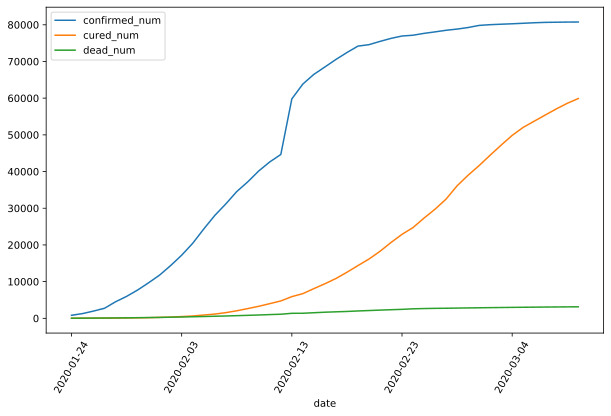

In [5]:
df.plot(x = 'date', y = ['confirmed_num', 'cured_num', 'dead_num'], figsize = (10,6))
plt.xticks(rotation = 60)

In [6]:
dfdata = df.set_index('date') # 用date列的时间作为每行数据的index（原来每行数据的index为0，1，...）
dfdiff = dfdata.diff(periods = 1).dropna() # diff求每行(period=1, 以第一行为基准作差，axis代表列)间的增量，去掉第一日的NaN（不是去掉所有等于0.0的）
dfdiff = dfdiff.reset_index('date') # 将此时为index的date重新恢复成一列
dfdiff.head(10)

,date,confirmed_num,cured_num,dead_num
0,2020-01-25,457.0,4.0,16.0
1,2020-01-26,688.0,11.0,15.0
2,2020-01-27,769.0,2.0,24.0
3,2020-01-28,1771.0,9.0,26.0
4,2020-01-29,1459.0,43.0,26.0
5,2020-01-30,1737.0,21.0,38.0
6,2020-01-31,1981.0,47.0,43.0
7,2020-02-01,2099.0,88.0,30.0
8,2020-02-02,2589.0,69.0,61.0
9,2020-02-03,2825.0,147.0,57.0


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

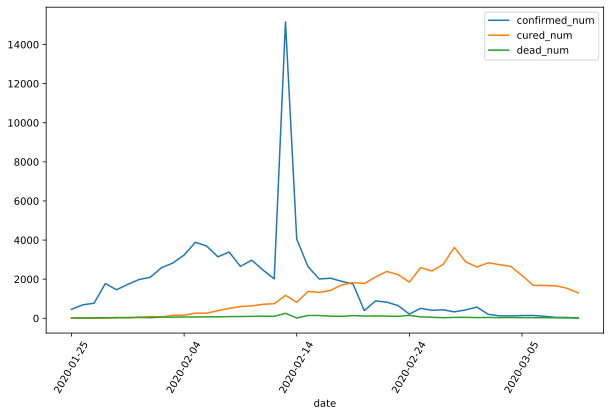

In [7]:
dfdiff.plot(x = 'date', y = ['confirmed_num', 'cured_num', 'dead_num'], figsize = (10,6))
plt.xticks(rotation = 60)

In [8]:
dfdiff = dfdiff.drop('date', axis = 1).astype("float32") # 删掉date列
dfdiff.head(10)

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
1,688.0,11.0,15.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
4,1459.0,43.0,26.0
5,1737.0,21.0,38.0
6,1981.0,47.0,43.0
7,2099.0,88.0,30.0
8,2589.0,69.0,61.0
9,2825.0,147.0,57.0


```python
通过继承torch.utils.data.Dataset实现自定义时间序列数据集。

torch.utils.data.Dataset是一个抽象类，用户想要加载自定义的数据只需要继承这个类，并且覆写其中的两个方法即可：

__len__:实现len(dataset)返回整个数据集的大小。
__getitem__:用来获取一些索引的数据，使dataset[i]返回数据集中第i个样本。
不覆写这两个方法会直接返回错误。
```

In [9]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

class Covid19Dataset(Dataset):
    def __len__(self):
        return len(dfdiff) - WINDOW_SIZE
    
    def __getitem__(self, i):
        x = dfdiff.loc[i:i+WINDOW_SIZE-1, :] # 行切片
        feature = torch.tensor(x.values)
        y = dfdiff.loc[i+WINDOW_SIZE, :]
        label = torch.tensor(y.values)
        return (feature, label)

ds_train = Covid19Dataset()

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
# dfdiff 46条数据 46-9+1 = 38 个 batch 
dl_train = DataLoader(ds_train, batch_size = 38)

In [10]:
for f, l in dl_train:
    print(f.shape, l.shape)
    break

torch.Size([38, 8, 3]) torch.Size([38, 3])


## 二、定义模型
使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器进行封装。

此处选择第二种方式构建模型。

Model类实际上继承自nn.Module类。

In [11]:
import torch
from torch import nn 
import importlib 
import torchkeras 

# 设置随机数种子 使训练结果可复现？
# 设置用于产生随机数，以非确定性的随机数种子。返回用于播种RNG一个64位的数。
torch.random.seed()

class Block(nn.Module):
    def __init__(self):
        super(Block, self).__init__()
        
    def forward(self, x, x_input):
        x_out = torch.max((1+x) * x_input[:, -1, :], torch.tensor(0.0))
        return x_out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 3层LSTM
        self.lstm = nn.LSTM(input_size=3, hidden_size=3, num_layers=5, batch_first=True)
        self.linear = nn.Linear(3, 3)
        self.block = Block()
        
    def forward(self, x_input):
        x = self.lstm(x_input)[0][:, -1, :]
        x = self.linear(x)
        y = self.block(x, x_input)
        return y

net = Net()
model = torchkeras.Model(net)

In [12]:
print(model)
model.summary(input_shape=(8, 3), input_dtype=torch.FloatTensor)

Model(
  (net): Net(
    (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
    (linear): Linear(in_features=3, out_features=3, bias=True)
    (block): Block()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1                 [-1, 8, 3]             480
            Linear-2                    [-1, 3]              12
             Block-3                    [-1, 3]               0
Total params: 492
Trainable params: 492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000092
Forward/backward pass size (MB): 0.000229
Params size (MB): 0.001877
Estimated Total Size (MB): 0.002197
----------------------------------------------------------------


In [13]:
# 定义Loss函数: mean squared prediction error

def mspe(y_pred, y_true):
    err_percent = (y_true - y_pred)**2/(torch.max(y_true**2, torch.tensor(1e-7)))
    return torch.mean(err_percent)

model.compile(loss_func = mspe, 
              optimizer = torch.optim.Adagrad(model.parameters(),lr = 0.1))

# 这里用Adam效果不好，为什么？ 

In [14]:
dfhistory = model.fit(100, dl_train, log_step_freq=10)

Start Training ...

================================================================================2020-11-06 15:59:32

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   1   | 3.893 |
+-------+-------+

================================================================================2020-11-06 15:59:32

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   2   | 2.033 |
+-------+-------+

================================================================================2020-11-06 15:59:32

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   3   | 1.227 |
+-------+-------+

================================================================================2020-11-06 15:59:32

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   4   | 0.742 |
+-------+-------+

================================================================================2020-11-06 15:59:32

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   5   | 0.555 |
+-------+-------+

===============


 +-------+-------+
| epoch |  loss |
+-------+-------+
|   43  | 0.295 |
+-------+-------+

================================================================================2020-11-06 15:59:33

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   44  | 0.294 |
+-------+-------+

================================================================================2020-11-06 15:59:33

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   45  | 0.293 |
+-------+-------+

================================================================================2020-11-06 15:59:33

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   46  | 0.293 |
+-------+-------+

================================================================================2020-11-06 15:59:33

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   47  | 0.292 |
+-------+-------+

================================================================================2020-11-06 15:59:33

 +-------+-------+
| epoch |  loss


 +-------+-------+
| epoch |  loss |
+-------+-------+
|   89  | 0.274 |
+-------+-------+

================================================================================2020-11-06 15:59:33

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   90  | 0.272 |
+-------+-------+

================================================================================2020-11-06 15:59:33

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   91  | 0.271 |
+-------+-------+

================================================================================2020-11-06 15:59:33

 +-------+------+
| epoch | loss |
+-------+------+
|   92  | 0.27 |
+-------+------+

================================================================================2020-11-06 15:59:33

 +-------+-------+
| epoch |  loss |
+-------+-------+
|   93  | 0.269 |
+-------+-------+

================================================================================2020-11-06 15:59:34

 +-------+-------+
| epoch |  loss |
+-

## 四、评估模型

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


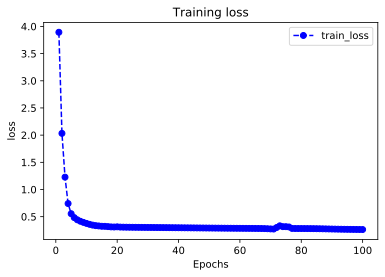

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric])
    plt.show()

plot_metric(dfhistory,"loss")

In [16]:
model.evaluate(dl_train)

{'val_loss': 0.26262402534484863}

## 五、使用模型

此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

In [17]:
dfresult = dfdiff[['confirmed_num', 'cured_num', 'dead_num']].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [18]:
# 预测此后500天的新增走势，将结果添加至dfresult

for i in range(500):
    # 最后38条数据; numpy转为tensor; unsqueeze维度扩充 torch.Size([38, 3]) -> torch.Size([1, 38, 3])
    arr_input = torch.unsqueeze(torch.from_numpy(dfresult.values[-38:,:]), axis = 0)
    arr_predict = model.forward(arr_input)
    # torch.floor床函数 返回输入tensor每个元素的floor，即不小于元素的最大整数
    dfpredict = pd.DataFrame(torch.floor(arr_predict).data.numpy(), columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [19]:
# 新增确证为0的时间

dfresult.query("confirmed_num == 0").head()

,confirmed_num,cured_num,dead_num
50,0.0,1020.0,5.0
51,0.0,972.0,4.0
52,0.0,926.0,3.0
53,0.0,882.0,2.0
54,0.0,840.0,1.0


In [20]:
# 新增治愈为0的时间

dfresult.query("cured_num == 0").head()

,confirmed_num,cured_num,dead_num
143,0.0,0.0,0.0
144,0.0,0.0,0.0
145,0.0,0.0,0.0
146,0.0,0.0,0.0
147,0.0,0.0,0.0


In [21]:
# 新增死亡为0的时间

dfresult.query("dead_num == 0").head()

,confirmed_num,cured_num,dead_num
55,0.0,800.0,0.0
56,0.0,762.0,0.0
57,0.0,726.0,0.0
58,0.0,692.0,0.0
59,0.0,659.0,0.0


## 六、保存模型

In [22]:
print(model.net.state_dict().keys())

odict_keys(['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'lstm.weight_ih_l2', 'lstm.weight_hh_l2', 'lstm.bias_ih_l2', 'lstm.bias_hh_l2', 'lstm.weight_ih_l3', 'lstm.weight_hh_l3', 'lstm.bias_ih_l3', 'lstm.bias_hh_l3', 'lstm.weight_ih_l4', 'lstm.weight_hh_l4', 'lstm.bias_ih_l4', 'lstm.bias_hh_l4', 'linear.weight', 'linear.bias'])


In [23]:
# 保存模型参数
# 如果目录不存在则创建目录
model_save_path = './result/1-4/'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

torch.save(model.state_dict(), model_save_path+'model_parameter.pkl')

In [24]:
net_clone = Net()
# 解决RuntimeError: Error(s) in loading state_dict for Net错误， DataParallel无用，load_state_dict加strict=False
# net_clone = nn.DataParallel(net_clone, device_ids=range(torch.cuda.device_count())) 
net_clone.load_state_dict(torch.load(model_save_path+'model_parameter.pkl'), strict=False)
model_clone = torchkeras.Model(net_clone)
model_clone.compile(loss_func = mspe)

# 评估模型
model_clone.evaluate(dl_train)

{'val_loss': 1.8162776231765747}